In [41]:
import os
import numpy as np
from numpy import dot
from numpy.linalg import norm
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. 전체 synopsis 파일을 이용해서 Word2Vec 모델 만들기

In [18]:
# 전체 Synopsis 파일을 이용해서 Word2Vec 임베딩 모델 만들기
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]: # 명사일 때만 tokenized에 저장
                res.append(w[0])
        tokenized.append(res)
print(f'전체 문장 수: {len(tokenized)}')

71156


In [21]:
# tokenized에 담긴 데이터를 가지고 Word2Vec을 생성 (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [23]:
# 결과 테스트
print(model.wv.most_similar(positive=['영화']))
print(model.wv.most_similar(positive=['사랑']))

[('작품', 0.8925426602363586), ('다큐멘터리', 0.8607804179191589), ('드라마', 0.8199335336685181), ('영화로', 0.8019460439682007), ('코미디', 0.7990570068359375), ('형식', 0.7767339944839478), ('영상', 0.7694631814956665), ('설정', 0.7686330080032349), ('에마데딘', 0.7683529257774353), ('감동', 0.7641177773475647)]
[('행복', 0.7206947803497314), ('첫사랑', 0.7144935131072998), ('애정', 0.7015505433082581), ('이별', 0.6871089339256287), ('연애', 0.6799245476722717), ('만인', 0.6730616092681885), ('진심', 0.6715319752693176), ('고백', 0.670031726360321), ('만남', 0.6696810722351074), ('열정', 0.6694671511650085)]


### 2. WEAT Score 함수

In [42]:
# 두 벡터의 코사인 유사도
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [ ]:
# 딘어 w의 편향성 - Target Set에 있는 단어 w가, Attribute Set A, B에 있는 단어들과의 유사도의 평균의 차이
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

In [35]:
# WEAT Score
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    return  (mean_X-mean_Y)/std_dev

### 3. Target Set 만들기

In [9]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]: #, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [51]:
# 예술 영화/상업 영화 텍스트 읽어서 토큰화
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [52]:
vectorizer = TfidfVectorizer()
tfidf_artgen = vectorizer.fit_transform([art, gen])

In [53]:
m1 = tfidf_artgen[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = tfidf_artgen[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술 영화를 대표하는 단어들 (중복 제거 전):')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반 영화를 대표하는 단어들 (중복 제거 전):')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술 영화를 대표하는 단어들 (중복 제거 전):
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

상업 영화를 대표하는 단어들 (중복 제거 전):
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [54]:
# 서로 독립적인 단어들을 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n:
        break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n:
        break

print('예술 영화를 대표하는 단어들 (중복 제거 후):', target_art)
print('일반 영화를 대표하는 단어들 (중복 제거 후):', target_gen)

예술 영화를 대표하는 단어들 (중복 제거 후): ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
상업 영화를 대표하는 단어들 (중복 제거 후): ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


### 4. Attribute Set 만들기

In [1]:
# 데이터 셋 준비
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

21


In [15]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [57]:
vectorizer = TfidfVectorizer()
tfidf_genre = vectorizer.fit_transform(genre)

In [58]:
print(tfidf_genre.shape)

m = [tfidf_genre[i].tocoo() for i in range(tfidf_genre.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

(21, 42191)
SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 

### 5. WEAT Score 구하기

In [29]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print(matrix)


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")


슝~


In [30]:
print(genre_name, len(genre_name))

['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지'] 21


In [32]:
print(attributes, len(attributes))

[['위해', '자신', '지구', '시작', '사람', '인류', '인간', '미래', '우주', '그녀', '로봇', '세계', '모든', '박사', '우주선'], ['엄마', '아빠', '가족', '영화제', '자신', '위해', '친구', '아주르', '아버지', '시작', '그녀', '아들', '마을', '국제', '낙타'], ['오페라', '사랑', '토스카', '실황', '올레', '자신', '카바', '그녀', '공연', '오텔로', '리골레토', '백작', '프레', '베르디', '위해'], ['시작', '위해', '사람', '자신', '친구', '그녀', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '남자', '좀비'], ['영화제', '국제', '서울', '단편', '영화', '자신', '사람', '이야기', '그녀', '남자', '위해', '시작', '사랑', '뉴미디어', '페스티벌'], ['영화제', '영화', '다큐', '국제', '다큐멘터리', '사람', '이야기', '대한', '자신', '감독', '위해', '서울', '우리', '시작', '세계'], ['자신', '영화제', '그녀', '사람', '사랑', '영화', '위해', '시작', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지'], ['그녀', '사랑', '자신', '시작', '남편', '남자', '여자', '사람', '친구', '섹스', '위해', '마음', '결혼', '서로', '아내'], ['뮤지컬', '사랑', '에스메랄다', '그녀', '음악', '충무로', '모차르트', '영화', '토스카', '자신', '니웨', '카바', '영화제', '바흐', '페뷔스'], ['사건', '그녀', '시작', '자신', '위해', '사람', '발견', '사고', '진실', '죽음', '기억', '살인', '친구', '아내', '남자'], ['사건', '위해', '자신', '경찰', '시작', '그녀', '범죄', '조

In [44]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])


SF 가족 -0.49655005
SF 공연 -0.3308758
SF 공포(호러) -0.6485982
SF 기타 0.35965562
SF 다큐멘터리 0.5956109
SF 드라마 -0.3353243
SF 멜로로맨스 -0.7673502
SF 뮤지컬 0.34860513
SF 미스터리 -0.64840835
SF 범죄 -0.21945179
SF 사극 -0.80131894
SF 서부극(웨스턴) -0.39392284
SF 성인물(에로) -0.5401165
SF 스릴러 -0.48987606
SF 애니메이션 0.37914142
SF 액션 -0.4492091
SF 어드벤처 -0.7531524
SF 전쟁 0.25280783
SF 코미디 -0.40711233
SF 판타지 -0.15442199
가족 공연 0.21342355
가족 공포(호러) -0.12919688
가족 기타 0.75856495
가족 다큐멘터리 0.8359027
가족 드라마 0.26612765
가족 멜로로맨스 -0.5883766
가족 뮤지컬 0.70524675
가족 미스터리 -0.25933605
가족 범죄 0.2216033
가족 사극 -0.07008693
가족 서부극(웨스턴) 0.44284937
가족 성인물(에로) -0.28362697
가족 스릴러 -0.09676968
가족 애니메이션 0.87379
가족 액션 0.11059115
가족 어드벤처 -0.0063591655
가족 전쟁 0.6765846
가족 코미디 0.24131952
가족 판타지 0.44658723
공연 공포(호러) -0.23887964
공연 기타 0.94161016
공연 다큐멘터리 0.9191954
공연 드라마 0.03109861
공연 멜로로맨스 -0.7014397
공연 뮤지컬 0.88377744
공연 미스터리 -0.33199424
공연 범죄 0.07021473
공연 사극 -0.37367105
공연 서부극(웨스턴) 0.02707626
공연 성인물(에로) -0.47371197
공연 스릴러 -0.19894667
공연 애니메이션 0.9199179
공연 액션 -0.

### 6. 시각화

<AxesSubplot:>

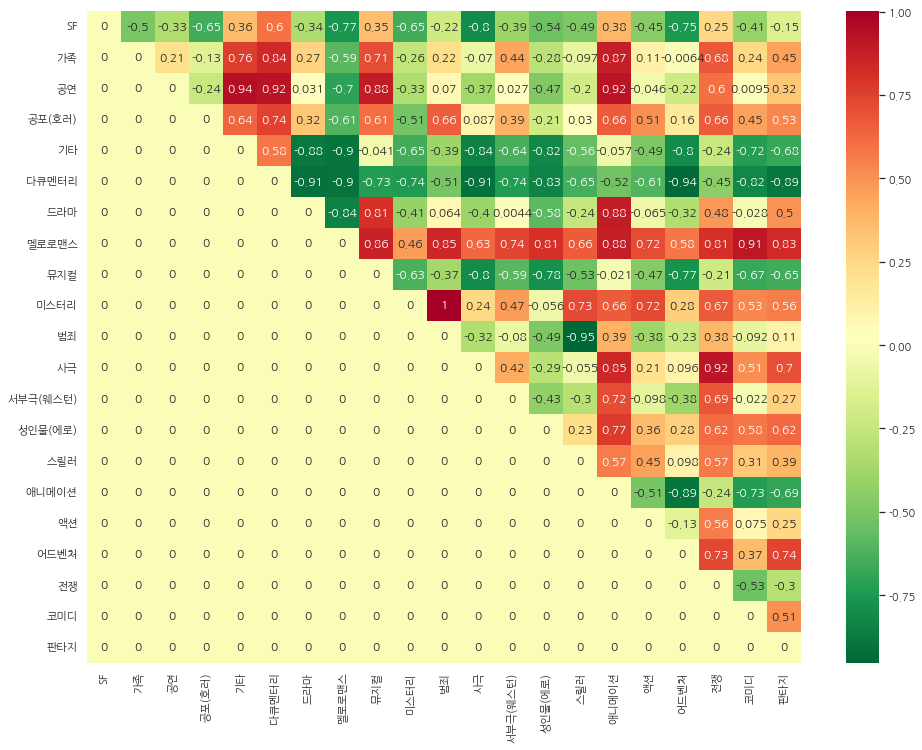

In [59]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

sns.set(font='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16,12)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax
